# Traffic Sign Recognition - with Tensor Flow

Using the Belgium Traffic Signs dataset [http://btsd.ethz.ch/shareddata/]. 

Two key files:

- BelgiumTSC_Training (171.3MBytes)
- BelgiumTSC_Testing (76.5MBytes)

**Acknowledgements**: 
- Based on Waleed Abdulla https://github.com/waleedka/traffic-signs-tensorflow



In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.data
import skimage.transform
from IPython import display

import tensorflow as tf
import keras

#inline plots
%matplotlib inline

Using TensorFlow backend.


In [2]:
# watermark the libs used
%load_ext watermark

%watermark -a 'Atul Acharya' -u -d -v -p numpy,tensorflow,matplotlib,sklearn,skimage,keras

Atul Acharya 
last updated: 2016-11-30 

CPython 3.5.2
IPython 5.0.0

numpy 1.11.2
tensorflow 0.11.0rc2
matplotlib 1.5.1
sklearn 0.18
skimage 0.12.3
keras 1.1.0


## First: Traffic Sign Classification



### Training Dataset

The data is stored in `./data/` directory, which has following directories:

```
- data/Training/
- data/Testing/


**********************************************
Archive content
**********************************************
This archive contains the following structure:

There is one directory for each of the 62 classes (00000 - 00061).
Each directory contains the corresponding training images and one 
text file with annotations, eg. GT-00000.csv. 

In total are 4591 images for training. On average for each physically distinct
traffic sign there are 3 images available.


**********************************************
Image format and naming
**********************************************
The images are PPM images (RGB color). Files are numbered in two parts:

   XXXXX_YYYYY.ppm

The first part, XXXXX, represents the pole number from where is in the full
annotations of BelgiumTS database. All images of one class 
with identical pole numbers originate from the same pole and more represent
one single physical traffic sign.

The second part, YYYYY, is a running number for the views where the traffic
sign is annotated. There is no temporal order
of the images, but they were where extracted in the order of the annotations on
the original pole from BelgiumTS.

**********************************************
Annotation format
**********************************************

The annotations are stored in CSV format (field separator
is ";" (semicolon) ). The annotations contain meta information 
about the image and the class id.


In detail, the annotations provide the following fields:

Filename        - Image file the following information applies to
Width, Height   - Dimensions of the image
Roi.x1,Roi.y1,
Roi.x2,Roi.y2   - Location of the sign within the image
                  (Images contain a border around the actual sign
                  of 10 percent of the sign size, at least 5 pixel)
ClassId         - The class of the traffic sign

```

In short, the **labels** of the Traffic Signs are the directory names (00-61), and within each directory are N images for that label. Each image is a file `*.ppm`. The `skimage` library handles the `.ppm` formatted image file.


In [3]:
# let's list all the image files in the directory
def load_images_labels(data_dir):
    """
        Loads images and labels from the data_dir
        Returns two lists:
        
        images: numpy array of images
        labels: numpy array of labels
    """
    # get all sub-directories in data_dir. Each in a label
    dirs = [d for d in os.listdir(data_dir) 
           if os.path.isdir(os.path.join(data_dir, d))]
    
    # loop thru all dirs, and collect data in two lists
    labels = []
    images = []
    for d in dirs:
        label_dir = os.path.join(data_dir, d)
        filenames = [os.path.join(label_dir, f)
                    for f in os.listdir(label_dir) if f.endswith('.ppm')]
        # for each label, load it's images to the images array
        # and load the label name to labels array
        for f in filenames:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

ROOT_DIR = './data'
train_data_dir = os.path.join(ROOT_DIR, "BelgiumTS/Training")
test_data_dir  = os.path.join(ROOT_DIR, "BelgiumTS/Testing")

# fetch Training data: Images and Labels
images, labels = load_images_labels(train_data_dir)

print('Images len:', len(images))
print('Labels len:', len(labels))

Images len: 4575
Labels len: 4575


In [4]:
print ('Unique labels: {0}\nTotal images: {1}'.format(len(set(labels)), len(images)) )

Unique labels: 62
Total images: 4575


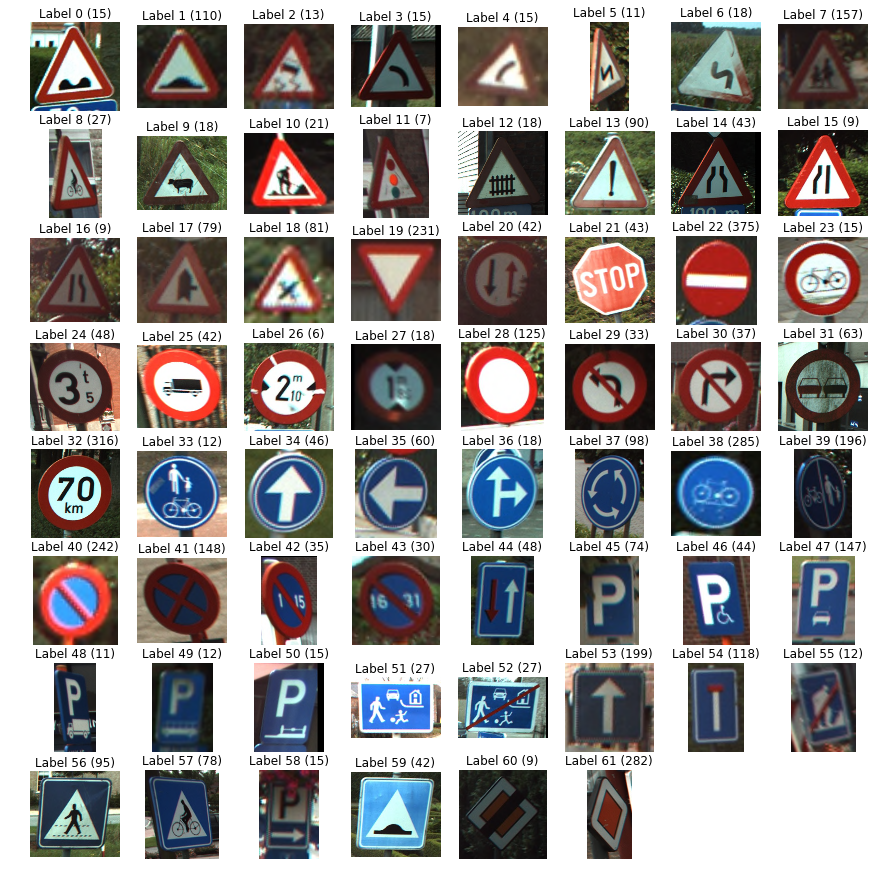

In [5]:
# Lets display some images and labels
def show_images_labels(images, labels):
    """ Display first image of each label """
    unique_labels = set(labels)
    plt.figure(figsize=(15,15))
    i = 1
    for label in unique_labels:
        # get the first image
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # grid of 8x8
        plt.axis('off')
        plt.title('Label {0} ({1})'.format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

show_images_labels(images, labels)

We notice several things. Some labels (e.g. 2, 3, 4, 5) have very few images, while others (e.g. 40, 41, 53, etc.) have lots of images. This may matter while training. Also, the images are square-ish, but not quite exactly square.

Let's explore couple of Labels in more detail.

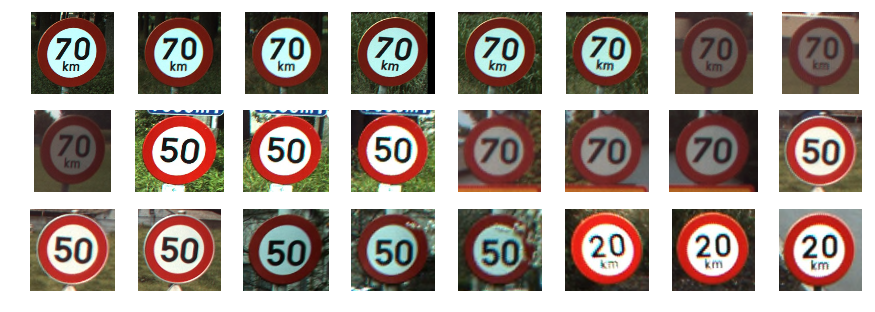

In [6]:
def show_images_in_label(images, label):
    """ Show a set of images in the given (single) label
    """
    limit = 24  # show max of 24 images
    plt.figure(figsize=(15,5))
    i = 1
    
    start = labels.index(label)
    end   = start + labels[start:].index(label+1)
    
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # grid of 3x8
        plt.axis('off')
        i += 1
        _ = plt.imshow(image)
    plt.show()
    
show_images_in_label(images, 32)

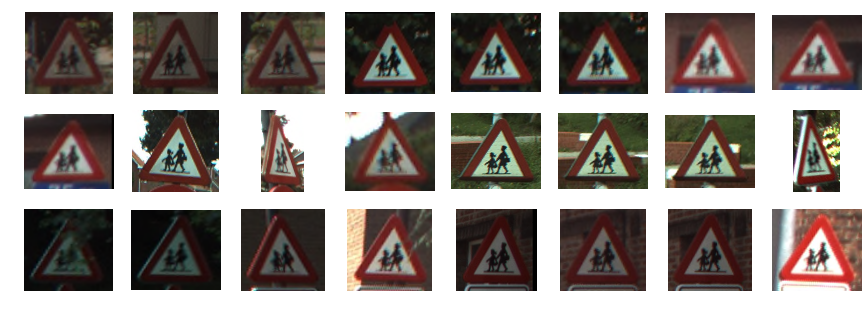

In [7]:
show_images_in_label(images, 7)

### Resizing images

Our images are not all the same size. Yet most NNs work best if the input is of the same size. 
Let's first see the sizes of current images. 

In [8]:
for img in images[50:55]:   # random
    print('Image shape: {0}, min: {1}, max: {2}'.format(img.shape, img.min(), img.max()))

Image shape: (160, 106, 3), min: 6, max: 255
Image shape: (123, 136, 3), min: 0, max: 255
Image shape: (139, 153, 3), min: 0, max: 255
Image shape: (130, 145, 3), min: 0, max: 255
Image shape: (87, 95, 3), min: 11, max: 255


Well, we really need to resize the images. Let's make them square (for now 32 x 32 pixels) and not worry about aspect ratio

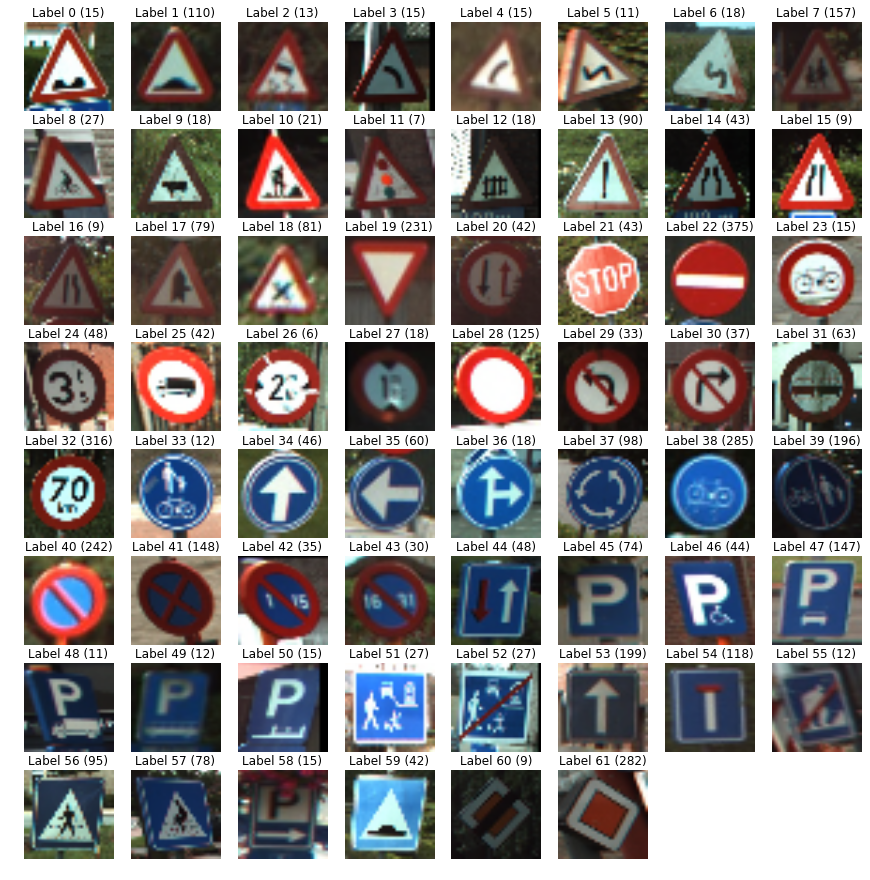

In [9]:
# Resize images
def resize(image_dataset, shape=(32,32)):
    """ Returns a new dataset with images resized to that specified by shape (default: 32x32)
    """
    return [skimage.transform.resize(image, shape)
           for image in image_dataset]

images32 = resize(images, shape=(32,32))

images64 = resize(images, shape=(64,64))

del images  # notify garbage collector to reduce memory

# show newly resized
show_images_labels(images32, labels)

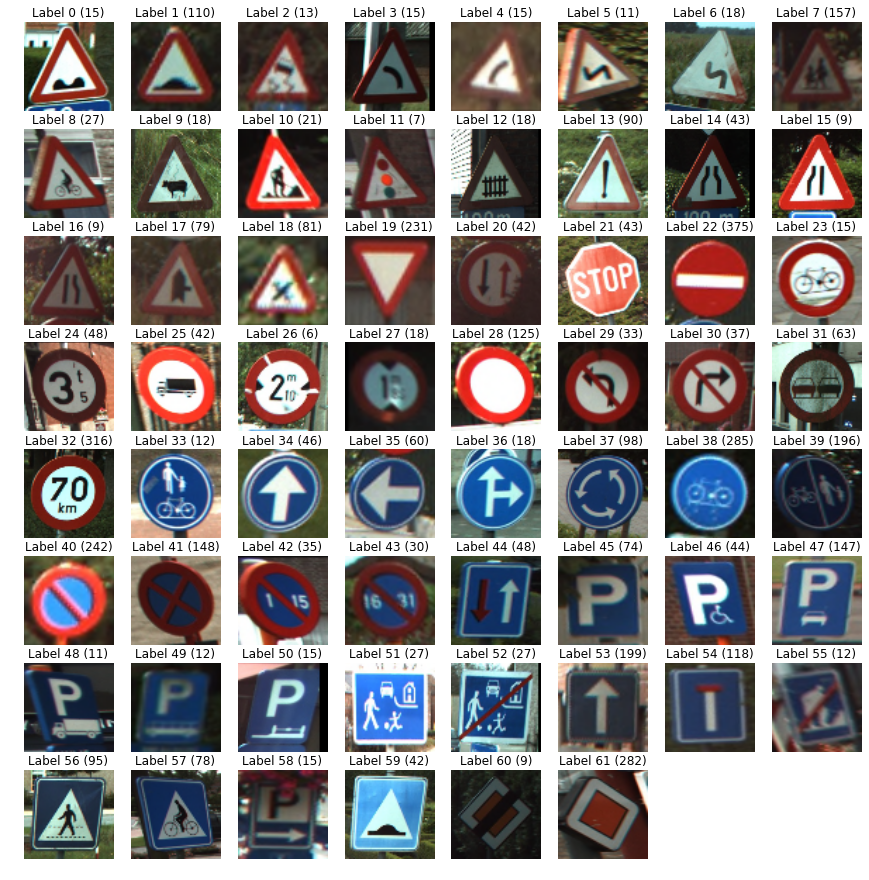

In [10]:
# show the 64x64 dataset
show_images_labels(images64, labels)

In [11]:
# let's examine the new 32x32 images:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.007391237745097838, max: 1.0
shape: (32, 32, 3), min: 0.0035768995098044943, max: 1.0
shape: (32, 32, 3), min: 0.0015567555147044665, max: 1.0
shape: (32, 32, 3), min: 0.05677466299019617, max: 0.9692670036764696
shape: (32, 32, 3), min: 0.026654411764708223, max: 0.9895220588235294


So the images are resized AND normalized

### Load Test Dataset



In [12]:
# Load Test dataset
test_images, test_labels = load_images_labels(test_data_dir)

# Transform images to 32x32
test_images32 = resize(test_images, shape=(32,32))
show_images_labels(test_images32, test_labels)

del test_images  # notify GC to release memory

### Randomize the dataset

Currently the dataset is not random. Randomize and shuffle it

In [14]:
images_train = np.array(images32)
labels_train = np.array(labels)

images_test = np.array(test_images32)
labels_test = np.array(test_labels)

In [15]:
np.random.seed(42)

# Randomize the dataset
def randomize(dataset, labels):
    ''' Returns randomized dataset and labels
    '''
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

In [17]:
# randomize Training
images_train, labels_train = randomize(images_train, labels_train)
# randomize Test
images_test, labels_test = randomize(images_test, labels_test)

print('Train images:', images_train.shape, ' labels:', labels_train.shape)
print('Test images:', images_test.shape, 'labels:', labels_test.shape)

Train images: (4575, 32, 32, 3)  labels: (4575,)
Test images: (2520, 32, 32, 3) labels: (2520,)


## Minimum Viable Model 



In [18]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
NUM_CHANNELS = 3
NUM_CLASSES = 62  # num of output labels

# Create a Graph to hold the model
graph = tf.Graph()

with graph.as_default():
    # placeholders for images and labels
    images_ph = tf.placeholder(tf.float32, [None, IMG_WIDTH, IMG_HEIGHT, NUM_CHANNELS])
    labels_ph = tf.placeholder(tf.int32, [None])
    
    # Flatten input from [None, Heigh, Width, Channels] 
    # To: [None, Height * Width * Channels]
    images_flat = tf.contrib.layers.flatten(images_ph)
    
    # ONE fully connected layer
    # Generates logits of size [None, NUM_CLASSES]
    logits = tf.contrib.layers.fully_connected(images_flat, NUM_CLASSES, tf.nn.relu)
    
    # convert logits to one-hot vector. Shape [None, NUM_CLASSES]
    predictions = tf.nn.softmax(logits)
    
    # convert one-hot vector to label index (int)
    # Shape [None], which is a 1D vector of length == BATCH SIZE
    predicted_labels = tf.argmax(predictions, 1)
    
    # Loss function
    # cross entropy
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, 
                                                                        labels_ph))
    
    # training step
    train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    
    # init all the vars
    init = tf.initialize_all_variables()
    
print("images_flat:", images_flat)
print("logits     :", logits)
print("loss       :", loss)
print("predictions:", predictions)
print("pred labels:", predicted_labels)


images_flat: Tensor("Flatten/Reshape:0", shape=(?, 3072), dtype=float32)
logits     : Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss       : Tensor("Mean:0", shape=(), dtype=float32)
predictions: Tensor("Softmax:0", shape=(?, 62), dtype=float32)
pred labels: Tensor("ArgMax:0", shape=(?,), dtype=int64)


## Training

In [19]:
# Create a session to run the graph
session = tf.Session(graph=graph)

# init the vars
session.run([init])

[None]

In [20]:
steps  = []
losses = []

for i in range(301):
    _, los = session.run([train_step, loss], 
                        feed_dict={images_ph: images_train, labels_ph: labels_train})
    steps.append(i)
    losses.append(los)
    
    if i % 50 == 0:
        print("step: ", i, " loss: ", los)


step:  0  loss:  4.12848
step:  50  loss:  1.87359
step:  100  loss:  1.62942
step:  150  loss:  1.51235
step:  200  loss:  1.4417
step:  250  loss:  1.39419
step:  300  loss:  1.36001


In [21]:
# Plot the loss
plt.figure(1, figsize=(10,10))
plt.subplot(221)
plt.plot(steps, losses)
plt.title('Min.FC Model: Losses')
plt.show()

## Evaluate on Test Data

In [22]:
#test_images_ar = np.array(test_images32)

# Run predictions on the Test dataset
predicted = session.run([predicted_labels], 
                       feed_dict={images_ph: images_test})[0]

# calc the matches
matches  = np.sum([int(y == y_) for y, y_ in zip(labels_test, predicted)])
accuracy = matches / len(test_labels)

print("Test Accuracy: {:.3f}%".format(accuracy*100))

Test Accuracy: 71.111%


In [23]:
# Close session. Destroys the trained model
session.close()

## Keras Model

Let's try a Keras based model for simplicity

In [24]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras import backend as K

# for CNN 
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D


In [25]:
# Use Tensor Flow style image dim ordering
K.set_image_dim_ordering('tf')    # order: Num Batches x Height x Width x Channels


In [26]:
BATCH_SIZE = 64
IMG_WIDTH = 32
IMG_HEIGHT = 32
NUM_CHANNELS = 3
NUM_CLASSES = 62 

# Num Conv filters
NB_FILTERS = 32

# Pooling size
POOL_SIZE = (2, 2)

# Conv Kernel size
KERNEL_SIZE = (3, 3)

In [28]:
# Reshape (if necessary)
x_train = images_train.reshape(images_train.shape[0], IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
x_test  = images_test.reshape (images_test.shape[0], IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

print(x_train.shape)
print(x_test.shape)

(4575, 32, 32, 3)
(2520, 32, 32, 3)


In [29]:
# 
y_train = np_utils.to_categorical(labels_train)
y_test  = np_utils.to_categorical(np.array(labels_test))

print(y_train.shape)
print(y_test.shape)

(4575, 62)
(2520, 62)


## NOTE!! Work-around for TensorFlow v0.11.rc2

See here: 
https://github.com/fchollet/keras/issues/3857

Simply do:
```
import tensorflow as tf
tf.python.control_flow_ops = tf
```

In [30]:
# See above workaround
import tensorflow as tf
tf.python.control_flow_ops = tf

In [31]:


## Define the CNN Model
cnn_model = Sequential()

# Conv layer 1
cnn_model.add(Convolution2D(NB_FILTERS,
                           KERNEL_SIZE[0],
                           KERNEL_SIZE[1],
                           border_mode='valid',
                           input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS),
                           name='conv1'))
# Activation 1
cnn_model.add(Activation('relu'))
# Pooling layer
cnn_model.add(MaxPooling2D(pool_size=POOL_SIZE))

# Dropout
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())

# Layer 2
cnn_model.add(Dense(128))
cnn_model.add(Activation('relu'))

# Last layer (#3)
cnn_model.add(Dense(NUM_CLASSES))
cnn_model.add(Activation('softmax'))   # get probabilities

# print model
cnn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv1 (Convolution2D)            (None, 30, 30, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 30, 30, 32)    0           conv1[0][0]                      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 15, 15, 32)    0           activation_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 15, 15, 32)    0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [32]:
# Compile the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])


In [ ]:
# Train/Fit the model
history = cnn_model.fit(x_train,
             y_train,
             validation_data=(x_test, y_test),
             nb_epoch=20,              # Just to test if everything is Ok
             batch_size=BATCH_SIZE,
             verbose=2)

Train on 4575 samples, validate on 2520 samples
Epoch 1/20
3s - loss: 2.3560 - acc: 0.4877 - val_loss: 1.5265 - val_acc: 0.6095
Epoch 2/20
3s - loss: 0.8928 - acc: 0.8050 - val_loss: 0.7444 - val_acc: 0.8222
Epoch 3/20
3s - loss: 0.4534 - acc: 0.8966 - val_loss: 0.5689 - val_acc: 0.8607
Epoch 4/20
3s - loss: 0.2547 - acc: 0.9456 - val_loss: 0.4380 - val_acc: 0.8897
Epoch 5/20
3s - loss: 0.1575 - acc: 0.9711 - val_loss: 0.3989 - val_acc: 0.8849
Epoch 6/20
3s - loss: 0.0906 - acc: 0.9886 - val_loss: 0.3903 - val_acc: 0.8845
Epoch 7/20
3s - loss: 0.0746 - acc: 0.9864 - val_loss: 0.3210 - val_acc: 0.9040
Epoch 8/20
4s - loss: 0.0476 - acc: 0.9943 - val_loss: 0.3321 - val_acc: 0.9099
Epoch 9/20
3s - loss: 0.0398 - acc: 0.9943 - val_loss: 0.3046 - val_acc: 0.9151
Epoch 10/20
4s - loss: 0.0292 - acc: 0.9956 - val_loss: 0.3186 - val_acc: 0.9194
Epoch 11/20
3s - loss: 0.0259 - acc: 0.9963 - val_loss: 0.3330 - val_acc: 0.9040
Epoch 12/20
4s - loss: 0.0232 - acc: 0.9967 - val_loss: 0.3094 - val_a

### Plot Accuracy and Loss



In [57]:
# Plot Accuracy
def plot_accuracy(history, model_name='model', y1='acc', y2='val_acc'):
    plt.plot(history.history[y1])
    plt.plot(history.history[y2])
    plt.title(model_name + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
 
# Plot Loss
def plot_loss(history, model_name='model', y1='loss', y2='val_loss'):
    plt.plot(history.history[y1])
    plt.plot(history.history[y2])
    plt.title(model_name + ' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


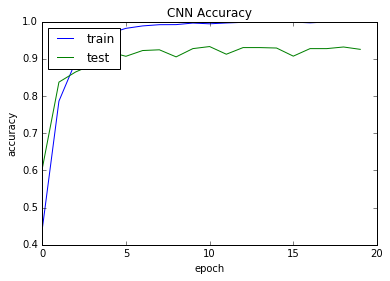

In [58]:
# plot the accuracy and loss
plot_accuracy(history, model_name='CNN')
plot_loss(history, model_name='CNN')

In [59]:
# Evaluate:
scores = cnn_model.evaluate(x_test, y_test)


2496/2520 [============================>.] - ETA: 0s

In [60]:
print(cnn_model.metrics)
print(scores)

['accuracy']
[0.29065779573353384, 0.92539682539682544]


### Accuracy ~92.5%

So we get a nice accuracy of ~92%!

### Improvements:

- Randomize & shuffle the Training & Test datasets!!  Currently, it is not random at all.
- Learning Rate Schedule
- Regularization
- Different CNN architecture (num. filters, max pool, avg pool, dropout)
- Deeper CNN ? 

